In [158]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np


In [159]:
ethnicity = pd.read_csv('ethnicity.csv', header=1)
ethnicity.reset_index(drop=True, inplace=True)
#Rename column headers 
ethnicity = ethnicity.rename(columns=lambda x: x.replace('Estimate!!RACE!!Total population!!One race!!', ''))
ethnicity = ethnicity.rename(columns=lambda x: x.replace('Margin of Error!!RACE!!Total population!!One race!!', 'MoE '))
ethnicity = ethnicity.rename(columns=lambda x: x.replace('Asian!!', ''))
ethnicity = ethnicity.drop('Geography', axis=1)
ethnicity.rename(columns={'Geographic Area Name':'City'}, inplace=True)

In [160]:
topcities = pd.read_csv('cities.csv')
#Some more reformatting
topcities = topcities.loc[:, ['Column1', '2021 estimate','2020 land area', '2020 population density']]
topcities = topcities.tail(-1)
topcities.rename(columns={'Column1': 'City','2021 estimate':'Population'}, inplace=True)
topcities['City'] = topcities['City'].replace('New York City, New York', 'New York, New York')

In [161]:
#Name fixing

pattern = r'( city| CDP| municipality|Urban | town|\-Richmond County consolidated government \(balance\)|\-Fayette urban county|\-Davidson metropolitan government \(balance\)|\-Clarke County unified government \(balance\)|\-Bibb County|/Jefferson County metro government \(balance\)|\(Ventura\)|\s\(balance\))'
asianpop = ethnicity['City'].str.replace(pattern, '').str.replace('Winston-Salem, North Carolina', 'Winston–Salem, North Carolina').str.strip()

#Edison and woodbridge are just straight up not in the data. despite me just brute forcing the names to match as above, i was considering just dropping these two.... EXCEPT i know for a fact edison has a huge asian population, maybe even taiwanese. since there are only two left, ill find the data and just add it in.
#Ok so apparently they only have outdated 2010 data. lets just hope that it didnt change that much
ethnicity['City'] = asianpop
edison = pd.DataFrame({'City': 'Edison, New Jersey', 'Asian': 42842, 'Asian Indian':28286,'Chinese':7915,'Filipino':2475},
                          index=["blah"])
wood = pd.DataFrame({'City': 'Woodbridge, New Jersey', 'Asian': 22137, 'Asian Indian':15827},
                          index=["blah"])

ethnicity = pd.concat([ethnicity, edison, wood], ignore_index=True)
ethnicity = ethnicity.drop_duplicates(subset='City')

C:\Users\match\AppData\Local\Temp\ipykernel_58464\2584680892.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  asianpop = ethnicity['City'].str.replace(pattern, '').str.replace('Winston-Salem, North Carolina', 'Winston–Salem, North Carolina').str.strip()


In [162]:
# New Thing!

top_ethnicities = pd.merge(topcities, ethnicity, on='City', how='left')

state_abbr = {
    ', Alabama': ', AL',
    ', Alaska': ', AK',
    ', Arizona': ', AZ',
    ', Arkansas': ', AR',
    ', California': ', CA',
    ', Colorado': ', CO',
    ', Connecticut': ', CT',
    ', Delaware': ', DE',
    ', Florida': ', FL',
    ', Georgia': ', GA',
    ', Hawaii': ', HI',
    ', Idaho': ', ID',
    ', Illinois': ', IL',
    ', Indiana': ', IN',
    ', Iowa': ', IA',
    ', Kansas': ', KS',
    ', Kentucky': ', KY',
    ', Louisiana': ', LA',
    ', Maine': ', ME',
    ', Maryland': ', MD',
    ', Massachusetts': ', MA',
    ', Michigan': ', MI',
    ', Minnesota': ', MN',
    ', Mississippi': ', MS',
    ', Missouri': ', MO',
    ', Montana': ', MT',
    ', Nebraska': ', NE',
    ', Nevada': ', NV',
    ', New Hampshire': ', NH',
    ', New Jersey': ', NJ',
    ', New Mexico': ', NM',
    ', New York': ', NY',
    ', North Carolina': ', NC',
    ', North Dakota': ', ND',
    ', Ohio': ', OH',
    ', Oklahoma': ', OK',
    ', Oregon': ', OR',
    ', Pennsylvania': ', PA',
    ', Rhode Island': ', RI',
    ', South Carolina': ', SC',
    ', South Dakota': ', SD',
    ', Tennessee': ', TN',
    ', Texas': ', TX',
    ', Utah': ', UT',
    ', Vermont': ', VT',
    ', Virginia': ', VA',
    ', Washington': ', WA',
    ', West Virginia': ', WV',
    ', Wisconsin': ', WI',
    ', Wyoming': ', WY'
}

# Replace state names with state abbreviations in the 'City' column
top_ethnicities = (
    top_ethnicities
    .replace(state_abbr, regex=True)
    .assign(Population=lambda x: x['Population'].str.replace(',', '').astype(int))
    .assign(Area=lambda x: x['2020 land area'].str.replace('\xa0sq\xa0mi', '').str.replace(',', '').astype(float))
    .assign(PopDensity=lambda x: x['2020 population density'].str.replace('/sq\xa0mi', '').str.replace(',', '').astype(float))
    .drop(columns=['2020 land area', '2020 population density'])
)

#Finally, split cities and states into own column
top_ethnicities[['City', 'State']] = top_ethnicities['City'].str.split(',', 1, expand=True)
top_ethnicities['State'] = top_ethnicities['State'].str.strip() #remove spaces
top_ethnicities.to_csv('cleancities.csv', index=False)



C:\Users\match\AppData\Local\Temp\ipykernel_58464\2068102743.py:69: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  top_ethnicities[['City', 'State']] = top_ethnicities['City'].str.split(',', 1, expand=True)


In [163]:
boba1 = pd.read_csv('bubbletea.csv')
boba2 = pd.read_csv('flushing.csv')
#So i realized after looking at the data in Tableau that "New York" seemed to be missing about a hundred stores. I realized that's mostly cuz flushing was counted as separate from 
#New york, so what better place than my birthplace to fix lol. 
boba = pd.concat([boba1, boba2], ignore_index=True)
#Drop duplicates (Caused by the 25 mile radius from city center)
boba_unique=boba.drop_duplicates(subset='ID')

#Boba_unique has 5737, more than the previous guy's- makes sense because new stores have likely come up, as well as more cities being added.
boba_unique['City_State'] = boba_unique.apply(lambda x: f"{x['City']}, {x['State']}", axis=1)
boba_unique.to_csv('cleanboba.csv',index=False)
#This should be a useful metric for a couple of stats.
boba_counts = boba_unique.groupby('City_State')['ID'].count()
print(boba_counts.describe())

top_ethnicities['City_State'] = top_ethnicities.apply(lambda x: f"{x['City']}, {x['State']}", axis=1)

merged_data = pd.merge(boba_counts, top_ethnicities, on='City_State')
merged_data['Residents per Boba Shop'] = merged_data['Population'] / merged_data['ID']
merged_data.to_csv('merged.csv',index=False)


count    1036.000000
mean        5.650579
std        17.096473
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max       444.000000
Name: ID, dtype: float64


C:\Users\match\AppData\Local\Temp\ipykernel_58464\3628248998.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boba_unique['City_State'] = boba_unique.apply(lambda x: f"{x['City']}, {x['State']}", axis=1)


In [164]:
# Final tables
print(merged_data.info())
print(boba_unique.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 313 entries, 0 to 312
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   City_State                                  313 non-null    object 
 1   ID                                          313 non-null    int64  
 2   City                                        313 non-null    object 
 3   Population                                  313 non-null    int32  
 4   Asian                                       310 non-null    object 
 5   Asian Indian                                310 non-null    object 
 6   Chinese                                     309 non-null    object 
 7   Filipino                                    309 non-null    object 
 8   Japanese                                    308 non-null    object 
 9   Korean                                      308 non-null    object 
 10  Vietnamese    

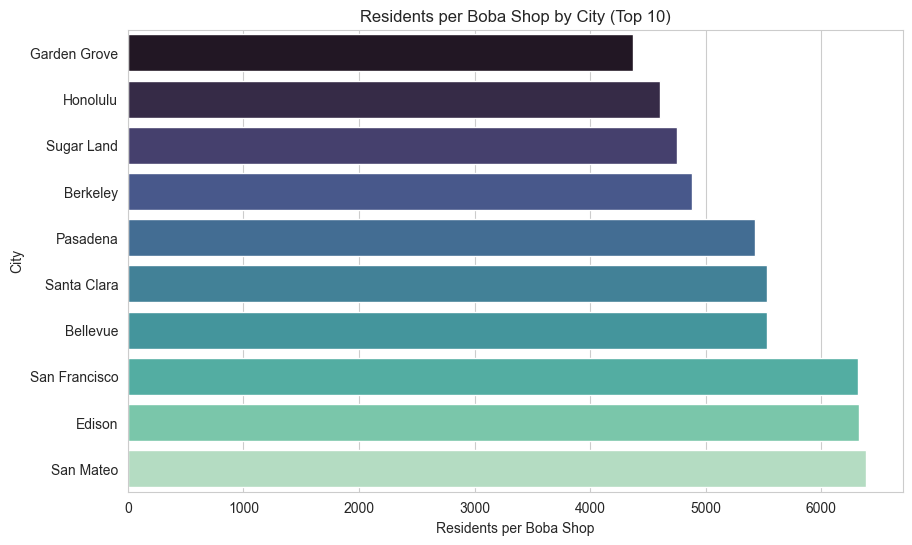

In [165]:
# Sort merged_data by "Residents per Boba Shop" and take the top ten rows
merged_data_top10 = merged_data.sort_values(by='Residents per Boba Shop', ascending=True).head(10)

# Create a figure with a wider canvas
fig, ax = plt.subplots(figsize=(10, 6))

# Creating bar chart
sns.barplot(data=merged_data_top10, y='City', x='Residents per Boba Shop', ax=ax, palette='mako')

# Add labels and title
ax.set_xlabel('Residents per Boba Shop')
ax.set_ylabel('City')
ax.set_title('Residents per Boba Shop by City (Top 10)')


plt.show()

In [166]:
transformtoint = ['Asian', 'Asian Indian', 'Korean', 'Chinese','Filipino','Japanese','Vietnamese','Other Asian']
for column in transformtoint:
    merged_data[column] = pd.to_numeric(merged_data[column], errors='coerce').fillna(0).astype(int)

In [167]:



merged_data['Percent Asian'] = merged_data['Asian']/merged_data['Population']
merged_data['Percent Chinese'] = merged_data['Chinese']/merged_data['Population']
merged_data['Percent Korean'] = merged_data['Korean']/merged_data['Population']
merged_data['Percent Indian'] = merged_data['Asian Indian']/merged_data['Population']
merged_data['Percent Japanese'] = merged_data['Japanese']/merged_data['Population']
merged_data['Percent Filipino'] = merged_data['Filipino']/merged_data['Population']
merged_data['Percent Vietnamese'] = merged_data['Vietnamese']/merged_data['Population']
merged_data['Percent Other Asian'] = merged_data['Other Asian']/merged_data['Population']

# Group the data by City_State and select the count of boba stores and ethnicity percentages
grouped_data = merged_data.groupby('City_State').agg({
    'ID': 'max',
    'Percent Asian': 'first',
    'Percent Chinese': 'first',
    'Percent Korean': 'first',
    'Percent Indian': 'first',
    'Percent Japanese': 'first',
    'Percent Filipino': 'first',
    'Percent Vietnamese': 'first',
    'Percent Other Asian': 'first'
})
# Rename ID column 
grouped_data = grouped_data.rename(columns={'ID': 'Count of Boba Stores'})

merged_data = merged_data.set_index('City_State')
grouped_data['PopDensity'] = merged_data['PopDensity']
grouped_data['Population'] = merged_data['Population']



In [168]:
# Create a list of the column names
columns = ['Population', 'PopDensity','Percent Asian', 'Percent Chinese', 'Percent Korean', 'Percent Indian','Percent Japanese','Percent Filipino','Percent Vietnamese','Percent Other Asian']

# Calculate correlation coefficient and p-value and store in a list of tuples
corr_data = []
for col in columns:
    corr_coeff, p_value = pearsonr(grouped_data['Count of Boba Stores'], grouped_data[col])
    corr_data.append((col, corr_coeff, p_value))

# Create a DataFrame from the list of tuples
corr_df = pd.DataFrame(corr_data, columns=['Column Name', "Pearson's Correlation Coefficient", 'p-value'])

# Print the DataFrame
display(corr_df)

,Column Name,Pearson's Correlation Coefficient,p-value
0,Population,0.864968,3.890388e-95
1,PopDensity,0.548212,5.944104e-26
2,Percent Asian,0.270136,1.231250e-06
3,Percent Chinese,0.307904,2.678088e-08
4,Percent Korean,0.187262,8.707893e-04
5,Percent Indian,0.126054,2.574091e-02
6,Percent Japanese,0.171271,2.362135e-03
7,Percent Filipino,0.125225,2.673775e-02
8,Percent Vietnamese,0.161416,4.195033e-03
9,Percent Other Asian,0.210366,1.776061e-04


In [169]:
# Select only the relevant columns
df = grouped_data.loc[:, ['Count of Boba Stores', 'Population', 'PopDensity', 'Percent Asian']]
df['City_State'] = grouped_data.index

# Define the weights as the correlation coefficients
weights = [0.865, 0.548, 0.270]

# Calculate the distance between each city and Buffalo, NY
df['Distance'] = np.sqrt(((df['Population'] - df.loc['Buffalo, NY']['Population']) * weights[0]) ** 2 +
                         ((df['PopDensity'] - df.loc['Buffalo, NY']['PopDensity']) * weights[1]) ** 2 +
                         ((df['Percent Asian'] - df.loc['Buffalo, NY']['Percent Asian']) * weights[2]) ** 2)

# Sort the cities by distance and select the closest 5
closest_cities = df.sort_values(by=['Distance']).iloc[1:6]['City_State'].tolist()
similar_cities_data = df[df.index.isin(closest_cities + ['Buffalo, NY'])]
similar_cities_data = similar_cities_data.sort_values('Distance', ascending=True).head(6)
display(similar_cities_data)

,Count of Boba Stores,Population,PopDensity,Percent Asian,City_State,Distance
City_State,,,,,,
"Buffalo, NY",8,276807,6890.0,0.079680,"Buffalo, NY",0.000000
"Chula Vista, CA",13,277220,5554.0,0.140693,"Chula Vista, CA",814.638201
"Chandler, AZ",21,279458,4226.0,0.098330,"Chandler, AZ",2718.382361
"North Las Vegas, NV",5,274133,2592.0,0.060234,"North Las Vegas, NV",3301.131956
"Gilbert, AZ",9,273136,3906.0,0.060377,"Gilbert, AZ",3571.728449
"Madison, WI",9,269196,3390.0,0.082074,"Madison, WI",6857.214723


In [170]:

# Define the predictors and response variable
X = grouped_data[['Population', 'PopDensity', 'Percent Asian']]
y = grouped_data['Count of Boba Stores']

model = LinearRegression()
model.fit(X, y)

# Print the coefficients
print('Coefficients:', model.coef_)

# Final prediction, based on population, population density, and percent asian
grouped_data['City_State'] = grouped_data.index
buffalo_data = grouped_data.loc[grouped_data['City_State'] == 'Buffalo, NY']
buffalo_predictors = buffalo_data[['Population', 'PopDensity', 'Percent Asian']]
buffalo_stores = model.predict(buffalo_predictors)
print('Expected number of boba stores for Buffalo:', buffalo_stores[0])

Coefficients: [4.07950256e-05 1.02968202e-03 6.16812578e+01]
Expected number of boba stores for Buffalo: 14.65966532659302
